# 1. Preprocess data

In [1]:
# imporing necessary library
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [2]:
#load data
df = pd.read_csv('./amazon-sampled.csv', delimiter=';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product Name  4000 non-null   object 
 1   Brand Name    3375 non-null   object 
 2   Price         3933 non-null   float64
 3   Rating        3995 non-null   float64
 4   Reviews       3993 non-null   object 
 5   Review Votes  3883 non-null   float64
dtypes: float64(3), object(3)
memory usage: 187.6+ KB


In [4]:
df[['Rating','Reviews']].head(5)
# df['Rating'].max()

,Rating,Reviews
0,5.0,Purchased this phone for my parents who have d...
1,5.0,good phone with a top hardware and relative lo...
2,5.0,5.0' Phones Unlocked Android 5.1 MTK6580 Quad...
3,1.0,The item was not working at all
4,4.0,"This phone is pretty neat. For the price, it’..."


In [5]:
#Define preprocessing functions
def preprocess_text(text):
    if isinstance(text, str):  # Check if text is a string
        # Convert to lowercase
        text = text.lower()
        
        # Remove punctuation and special characters
        text = re.sub(r'[^\w\s]', '', text)
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
        
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
        return ' '.join(tokens)
    else:
        return ''  # Return an empty string for non-string inputs


In [6]:
print(df['Reviews'].head(5))

0    Purchased this phone for my parents who have d...
1    good phone with a top hardware and relative lo...
2     5.0' Phones Unlocked Android 5.1 MTK6580 Quad...
3                      The item was not working at all
4     This phone is pretty neat. For the price, it’...
Name: Reviews, dtype: object


In [7]:
#Apply preprocessing to the 'Reviews' column:
df['Processed_Reviews'] = df['Reviews'].apply(preprocess_text)

# Should I use the Process_reviews or just Reviews?? Hmmph
print(df['Processed_Reviews'].head(5))

# print(df['Reviews'].head(5))

0    purchased phone parent difficulty small button...
1           good phone top hardware relative low price
2    50 phone unlocked android 51 mtk6580 quad core...
3                                         item working
4    phone pretty neat price impressive especially ...
Name: Processed_Reviews, dtype: object


In [8]:
#Perform Named Entity Recognition (NER)
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag, ne_chunk
from nltk.corpus import stopwords
import re

def extract_entities(text):
    if not isinstance(text, str):
        return []  # Return an empty list if the text is not a string
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    entities = ne_chunk(tagged)
    return [entity for entity in entities if isinstance(entity, nltk.Tree)]


df['Reviews'] = df['Reviews'].fillna('')  # Replace NaN values with empty strings
df['Named_Entities'] = df['Reviews'].apply(extract_entities)


In [9]:
#Create a bag-of-words representation
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
bow_matrix = vectorizer.fit_transform(df['Processed_Reviews'])
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [10]:
#bow_df.head(5)

# Do we really need the Bag of word? For what purpose?

In [11]:
#Generate sentiment scores:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()
df['Sentiment_Scores'] = df['Reviews'].apply(lambda x: sia.polarity_scores(x))
df['Sentiment'] = df['Sentiment_Scores'].apply(lambda x: 'Positive' if x['compound'] > 0 else ('Negative' if x['compound'] < 0 else 'Neutral'))

In [12]:
#Extract additional features:
df['Review_Length'] = df['Reviews'].apply(len)
df['Word_Count'] = df['Reviews'].apply(lambda x: len(word_tokenize(x)))
df['Sentence_Count'] = df['Reviews'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [13]:
# Check for missing values

# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

# Handle missing values
df['Reviews'] = df['Reviews'].fillna('No review provided')
df['Brand Name'] = df['Brand Name'].fillna('Unknown')
df['Price'] = df['Price'].fillna(df['Price'].mean())
df['Rating'] = df['Rating'].fillna(df['Rating'].median())



Product Name           0
Brand Name           625
Price                 67
Rating                 5
Reviews                0
Review Votes         117
Processed_Reviews      0
Named_Entities         0
Sentiment_Scores       0
Sentiment              0
Review_Length          0
Word_Count             0
Sentence_Count         0
dtype: int64


In [14]:
# Remove duplicate reviews
df.drop_duplicates(subset=['Reviews'], keep='first', inplace=True)

In [15]:
# Standardize price format
df['Price'] = df['Price'].astype(float).round(2)

# Ensure rating is an integer between 1 and 5
df['Rating'] = df['Rating'].astype(int).clip(1, 5)

In [16]:
#Outlier Detection
import numpy as np

# Detect and handle price outliers using IQR method
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df['Price'] = np.where(df['Price'] < lower_bound, lower_bound, 
                       np.where(df['Price'] > upper_bound, upper_bound, df['Price']))

In [17]:
#Text Normalization
import re

def normalize_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

df['Normalized_Reviews'] = df['Reviews'].apply(normalize_text)

In [18]:
#Brand Name Standardization
if 'Brand Name' in df.columns:
    df['Brand Name'] = df['Brand Name'].replace({'Alcatel': 'ALCATEL', 'TCL Mobile': 'TCL', 'star': 'Star'})
else:
    print("Column 'Brand' does not exist in the DataFrame")


In [19]:
# Remove extremely short reviews (less than 5 words)
df = df[df['Reviews'].str.split().str.len() >= 5]

In [20]:
#Handling Non-English Reviews
!pip install langdetect

from langdetect import detect

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

df = df[df['Reviews'].apply(is_english)]

In [21]:
#Removing HTML Tags
df['Reviews'] = df['Reviews'].apply(lambda x: re.sub('<.*?>', '', x))

In [22]:
# Standardize product names
df['Product Name'] = df['Product Name'].str.replace('ALCATEL OneTouch', 'Alcatel OneTouch')
df['Product Name'] = df['Product Name'].str.replace('Iphone', 'iPhone')


In [23]:
# Final data quality check
print(df.info())
print(df.describe())

# Sample of cleaned data
print(df.sample(5))

<class 'pandas.core.frame.DataFrame'>
Index: 2981 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Product Name        2981 non-null   object 
 1   Brand Name          2981 non-null   object 
 2   Price               2981 non-null   float64
 3   Rating              2981 non-null   int32  
 4   Reviews             2981 non-null   object 
 5   Review Votes        2890 non-null   float64
 6   Processed_Reviews   2981 non-null   object 
 7   Named_Entities      2981 non-null   object 
 8   Sentiment_Scores    2981 non-null   object 
 9   Sentiment           2981 non-null   object 
 10  Review_Length       2981 non-null   int64  
 11  Word_Count          2981 non-null   int64  
 12  Sentence_Count      2981 non-null   int64  
 13  Normalized_Reviews  2981 non-null   object 
dtypes: float64(2), int32(1), int64(3), object(8)
memory usage: 337.7+ KB
None
             Price       Rating  Re

# 2. Sentiment analysis

## 2.1 Linear Regression

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, f1_score
import warnings

warnings.filterwarnings('ignore')

tfidf_vectorizer = TfidfVectorizer(
    tokenizer = lambda doc: doc, 
    lowercase = False,
    max_df=0.95,  # Ignore terms that appear in more than 95% of documents
    min_df=2,     # Ignore terms that appear in less than 2 documents
    max_features=1000  # Limit to 1000 features
    )

# Split the data into training and testing sets
x = tfidf_vectorizer.fit_transform(df['Processed_Reviews'])
y = df['Rating']

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.15,
                                                   random_state= 42)

# Train a Naive Bayes classifier
model = LinearRegression()
model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = model.predict(x_test)
y_pred_rounded = np.round(y_pred).astype(int) # Round y_pred to nearest integer
y_pred_rounded = np.clip(y_pred_rounded, 1, 5) # Clip values to ensure they're in the range 1-5

# Calculate and print Mean Squared Error
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred):1f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred_rounded, average='weighted')
print(f'F1 Score: {f1}')

# Calculate accuracy
accuracy_lr = accuracy_score(y_test, y_pred_rounded)
print(f'Linear regression Accuracy: {accuracy_lr:.4f}')

# Print classification report for detailed evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rounded))

Mean Squared Error: 2.389196
F1 Score: 0.13204506303498545
Linear regression Accuracy: 0.1562

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       104
           2       0.15      0.05      0.07        43
           3       0.07      0.40      0.12        35
           4       0.17      0.53      0.25        64
           5       0.83      0.10      0.18       202

    accuracy                           0.16       448
   macro avg       0.24      0.22      0.12       448
weighted avg       0.42      0.16      0.13       448



In [25]:
test_reviews = ["Bought this phone three weeks ago and now I regret it",
               "My grandmother said the phone that I gave her last month is good!",
               "This phone not worth the price",
               "GO BUY IT WHILE ITS AVAILABLE! YOU WON'T REGRET IT!",
               "I hate this",
               "Broken stuff",
               "Useful!",
               "Expensive!",
               "Disgusting!",
               "Wonderful~",
               "I like it",
               "I do not like it",
               "I do not want to use it",
               "He does not want to use it",
               "We like to use it"]

new_test_feature = tfidf_vectorizer.transform([preprocess_text(review) for review in test_reviews])

newPrediction = model.predict(new_test_feature)

for review, rating in zip(test_reviews, newPrediction):
    print(f'''
    Review: "{review}"
    Predicted rating: {int(rating)}''')


    Review: "Bought this phone three weeks ago and now I regret it"
    Predicted rating: 3

    Review: "My grandmother said the phone that I gave her last month is good!"
    Predicted rating: 4

    Review: "This phone not worth the price"
    Predicted rating: 3

    Review: "GO BUY IT WHILE ITS AVAILABLE! YOU WON'T REGRET IT!"
    Predicted rating: 4

    Review: "I hate this"
    Predicted rating: 3

    Review: "Broken stuff"
    Predicted rating: 4

    Review: "Useful!"
    Predicted rating: 3

    Review: "Expensive!"
    Predicted rating: 5

    Review: "Disgusting!"
    Predicted rating: 3

    Review: "Wonderful~"
    Predicted rating: 3

    Review: "I like it"
    Predicted rating: 3

    Review: "I do not like it"
    Predicted rating: 3

    Review: "I do not want to use it"
    Predicted rating: 2

    Review: "He does not want to use it"
    Predicted rating: 2

    Review: "We like to use it"
    Predicted rating: 2


## 2.2 Naive Bayes

In [26]:
# Split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(df['Processed_Reviews'], df['Rating'], test_size=0.2, random_state=42)

# Create a bag of words model
count_vectorizer = CountVectorizer()
X_train_vectorized = count_vectorizer.fit_transform(X_train2)
X_test_vectorized = count_vectorizer.transform(X_test2)

# Train a Naive Bayes classifier
nb_model = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
nb_model.fit(X_train_vectorized, y_train2)

# Make predictions on the test set
y_pred2 = nb_model.predict(X_test_vectorized)

# Calculate and print Mean Squared Error
print(f'Mean Squared Error: {mean_squared_error(y_test2, y_pred2):1f}')

# Calculate F1 score
f1 = f1_score(y_test2, y_pred2, average='weighted')
print(f"F1 score: {f1:.4f}")

# Calculate accuracy
print(f'Accuracy: {accuracy_score(y_test2, y_pred2)}')

# Print classification report for detailed evaluation
print("\nClassification Report:")
print(classification_report(y_test2, y_pred2))

Mean Squared Error: 2.371859
F1 score: 0.5089
Accuracy: 0.592964824120603

Classification Report:
              precision    recall  f1-score   support

           1       0.70      0.63      0.66       137
           2       0.20      0.02      0.03        55
           3       0.00      0.00      0.00        46
           4       0.27      0.11      0.16        91
           5       0.59      0.96      0.73       268

    accuracy                           0.59       597
   macro avg       0.35      0.34      0.32       597
weighted avg       0.49      0.59      0.51       597



In [27]:
# Test new reviews with Naive Bayes model
new_reviews = ["Bought this phone three weeks ago and now I regret it",
               "My grandmother said the phone that I gave her last month is good!",
               "This phone not worth the price",
               "GO BUY IT WHILE ITS AVAILABLE! YOU WON'T REGRET IT!",
               "I hate this",
               "Broken stuff",
               "Useful!",
               "Expensive!",
               "Disgusting!",
               "Wonderful~",
               "I like it",
               "I do not like it",
               "I do not want to use it",
               "He does not want to use it",
               "We like to use it"]

vectorized_new_reviews = count_vectorizer.transform(new_reviews)

predictions = nb_model.predict(vectorized_new_reviews)

for review, prediction in zip(new_reviews, predictions):
    print(f"Review: {review}")
    print(f"Predicted rating: {prediction}")
    print()

Review: Bought this phone three weeks ago and now I regret it
Predicted rating: 1

Review: My grandmother said the phone that I gave her last month is good!
Predicted rating: 1

Review: This phone not worth the price
Predicted rating: 5

Review: GO BUY IT WHILE ITS AVAILABLE! YOU WON'T REGRET IT!
Predicted rating: 5

Review: I hate this
Predicted rating: 5

Review: Broken stuff
Predicted rating: 1

Review: Useful!
Predicted rating: 5

Review: Expensive!
Predicted rating: 5

Review: Disgusting!
Predicted rating: 5

Review: Wonderful~
Predicted rating: 5

Review: I like it
Predicted rating: 5

Review: I do not like it
Predicted rating: 5

Review: I do not want to use it
Predicted rating: 5

Review: He does not want to use it
Predicted rating: 5

Review: We like to use it
Predicted rating: 5



## 2.3 Random Forest

In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Define rating categories
def categorize_ratings(rating):
    if rating <= 2:
        return 'Low'
    elif rating == 3:
        return 'Medium'
    else:
        return 'High'

df['Rating_Category'] = df['Rating'].apply(categorize_ratings)

# Encode categories as labels
label_encoder = LabelEncoder()
df['Rating_Label'] = label_encoder.fit_transform(df['Rating_Category'])

# Feature extraction
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=lambda doc: doc.split(), 
    lowercase=False,
    max_df=0.95, 
    min_df=2,     
    max_features=1000
)
X_features = tfidf_vectorizer.fit_transform(df['Processed_Reviews'])

# Split data into train/test sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_features, df['Rating_Label'], test_size=0.2, random_state=42)

# Train a Random Forest classifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train3, y_train3)

# Make predictions
y_pred3 = classifier.predict(X_test3)

# Calculate and print Mean Squared Error
mse_rf = mean_squared_error(df['Rating_Label'], classifier.predict(X_features))
print(f'\nRandom Forest Mean Squared Error: {mse_rf:.4f}')

# Calculate F1 score
f1 = f1_score(y_test3, y_pred3, average='weighted')
print(f'F1 Score: {f1}')

# Calculate accuracy
accuracy_rf = accuracy_score(y_test3, y_pred3)
print(f'Random Forest Accuracy: {accuracy_rf:.4f}')

# Print classification report for detailed evaluation
print("\nClassification Report:")
print(classification_report(y_test3, y_pred3, target_names=label_encoder.classes_))


Random Forest Mean Squared Error: 0.0765
F1 Score: 0.7342571515196358
Random Forest Accuracy: 0.7705

Classification Report:
              precision    recall  f1-score   support

        High       0.77      0.94      0.85       359
         Low       0.76      0.65      0.70       192
      Medium       0.00      0.00      0.00        46

    accuracy                           0.77       597
   macro avg       0.51      0.53      0.52       597
weighted avg       0.71      0.77      0.73       597



In [29]:
# Test new reviews with Random Forest model
new_reviews = ["Bought this phone three weeks ago and now I regret it",
               "My grandmother said the phone that I gave her last month is good!",
               "This phone not worth the price",
               "GO BUY IT WHILE ITS AVAILABLE! YOU WON'T REGRET IT!",
               "I hate this",
               "Broken stuff",
               "Useful!",
               "Expensive!",
               "Disgusting!",
               "Wonderful~",
               "I like it",
               "I do not like it",
               "I do not want to use it",
               "He does not want to use it",
               "We like to use it"]

# Preprocess new reviews and transform them into TF-IDF
new_reviews_processed = [preprocess_text(review) for review in new_reviews]
new_reviews_vectorized = tfidf_vectorizer.transform(new_reviews_processed)

# Predict ratings for new reviews
new_predictions = classifier.predict(new_reviews_vectorized)

# Print predictions for new reviews
for review, prediction in zip(new_reviews, new_predictions):
    print(f'\nReview: "{review}"')
    print(f'Predicted rating category: {label_encoder.inverse_transform([prediction])[0]}')


Review: "Bought this phone three weeks ago and now I regret it"
Predicted rating category: Low

Review: "My grandmother said the phone that I gave her last month is good!"
Predicted rating category: High

Review: "This phone not worth the price"
Predicted rating category: High

Review: "GO BUY IT WHILE ITS AVAILABLE! YOU WON'T REGRET IT!"
Predicted rating category: High

Review: "I hate this"
Predicted rating category: High

Review: "Broken stuff"
Predicted rating category: High

Review: "Useful!"
Predicted rating category: High

Review: "Expensive!"
Predicted rating category: High

Review: "Disgusting!"
Predicted rating category: High

Review: "Wonderful~"
Predicted rating category: High

Review: "I like it"
Predicted rating category: High

Review: "I do not like it"
Predicted rating category: High

Review: "I do not want to use it"
Predicted rating category: High

Review: "He does not want to use it"
Predicted rating category: High

Review: "We like to use it"
Predicted rating categ

# 3. COMPARISON

+-------------------+--------+------------+------------+
| Model             |    MSE |   Accuracy |   F1 Score |
+===================+========+============+============+
| Linear Regression | 2.3892 |     0.1562 |     0.1320 |
+-------------------+--------+------------+------------+
| Naive Bayes       | 2.3719 |     0.5930 |     0.5089 |
+-------------------+--------+------------+------------+
| Random Forest     | 0.0765 |     0.7705 |     0.7343 |
+-------------------+--------+------------+------------+


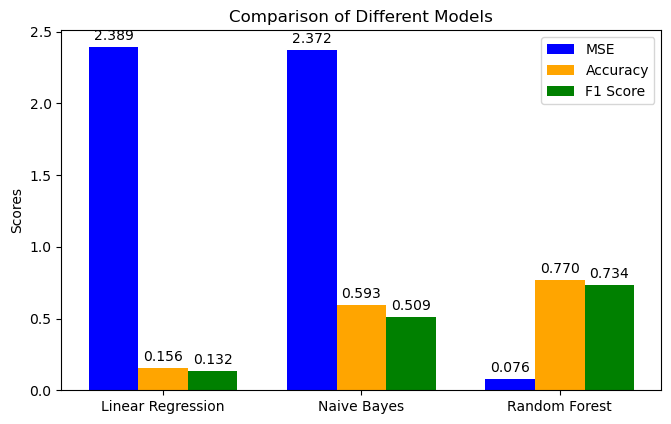

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# Create a list of lists for the table data
table_data = list(zip(models, mse, accuracy, f1_score))

# Create the table
headers = ["Model", "MSE", "Accuracy", "F1 Score"]
table = tabulate(table_data, headers=headers, floatfmt=".4f", tablefmt="grid")

print(table)

# Data for the graph
models = ['Linear Regression', 'Naive Bayes', 'Random Forest']
mse = [2.389196, 2.371859, 0.0765]
accuracy = [0.1562, 0.592964824120603, 0.7705]
f1_score = [0.13204506303498545, 0.5089, 0.7342571515196358]

x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, mse, width, label='MSE', color='blue')
rects2 = ax.bar(x, accuracy, width, label='Accuracy', color='orange')
rects3 = ax.bar(x + width, f1_score, width, label='F1 Score', color='green')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Comparison of Different Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Function to add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=0)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# fig.tight_layout()
plt.subplots_adjust(left=0.5, right=1, top=1, bottom=0.4)

plt.show()